# Housing ML Notebook

In [1]:
# Setup Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

# Display all rows and columns
pd.set_option("display.max_columns", None)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
import pickle

**saving models**
https://medium.com/fintechexplained/how-to-save-trained-machine-learning-models-649c3ad1c018

In [3]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2

In [4]:
# # Used for auto-formatting code
# # terminal - pip install nb_black
# %load_ext nb_black

In [5]:
# Import data csvs
X = pd.read_csv("data/predictors.csv")  # id=1 to 1460
Y = pd.read_csv("data/response.csv")  # id=1461-2919

# Save figures within notebook?
save_figures = 0  # 1 (yes); 0 (no)

In [6]:
# Dummify categorical predictors
X = pd.get_dummies(X, drop_first=True)  # dummify


In [7]:
# Separate train and test.csv dataframes
train_df = X.loc[X.Id <= 1460].drop("Id", axis=1)  # train.csv
test_df = X.loc[X.Id > 1460].drop("Id", axis=1)  # test.csv
response = Y

# Test-Train split **TRAIN.CSV DATA**
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    train_df, response, test_size=0.3, random_state=0
)

## Basic Models

### Lasso Regularized Regression

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2126 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 4926 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 8526 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   26.5s finished


Lasso: All Features
Best Lambda:0.00011994
Train RMSE:0.11001


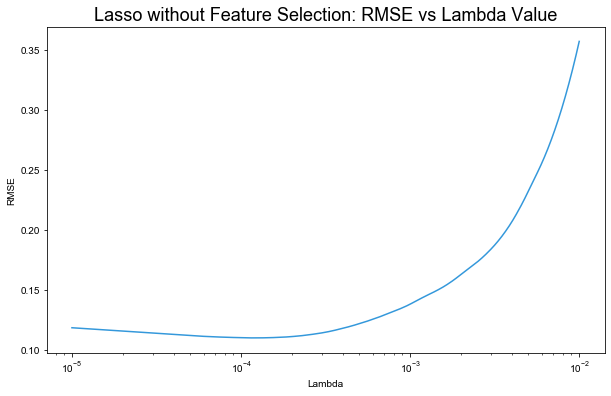

In [8]:
#New instance of model
lasso = Lasso(normalize=True, random_state=0)

#Perform gridsearch
# min_a = -7
# max_a = -2
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter


param_grid = {"alpha": np.linspace(10**-5, 10**-2, 2000)}
grid = GridSearchCV(estimator=lasso, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train, y_train) #fit training data to model
lasso_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(lasso_allFeatures, open('saved_models/lasso_allFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Lasso: All Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
# plt.xlim(10 ** min_a, 10 ** max_a)
# plt.ylim(0.10, 0.350)
plt.title("Lasso without Feature Selection: RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/lasso_allFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = lasso_allFeatures.predict(test_df) #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('lasso_allFeat_results.csv',index=False)


### Lasso Regularized Regression with Feature Selection

Number of selected features: 78
Number of dropped features: 122


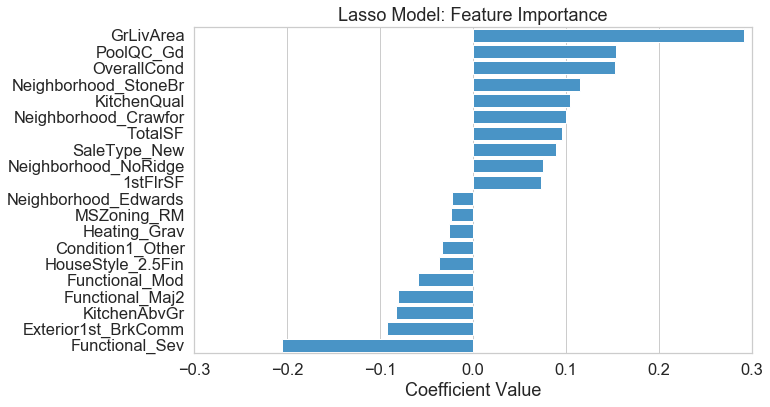

In [9]:
# Feature Selection
lasso_allFeatures.fit(x_train, y_train)  # fit model with training data
coefs_df = pd.DataFrame(lasso_allFeatures.coef_, index=x_train.columns, columns=["coef"]) #df of parameter coefficients
coefs_df.sort_values(ascending=False, by="coef", inplace=True)  # sort df
n_select = sum(coefs_df.coef != 0)  # features selected
n_drop = sum(coefs_df.coef == 0)  # features dropped
print('Number of selected features: {0}'.format(n_select))
print('Number of dropped features: {0}'.format(n_drop))

# Important features
imp_feat = coefs_df.loc[coefs_df.coef != 0].index.tolist()

# Plot coefficients of top 20 important features
plt.figure(figsize=(10, 6))
data = pd.concat([coefs_df.head(10), coefs_df.tail(10)], axis=0)
sns.barplot(x=data.coef, y=data.index, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
plt.title("Lasso Model: Feature Importance")
plt.xlabel("Coefficient Value")
plt.xlim(-0.3, 0.3)

if save_figures:
    plt.savefig("saved_figures/lasso_feat_importance.tiff", bbox_inches="tight")

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5032 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 9232 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   15.4s finished


Lasso: Selected Features
Best Lambda:1.501e-05
Train RMSE:0.10426


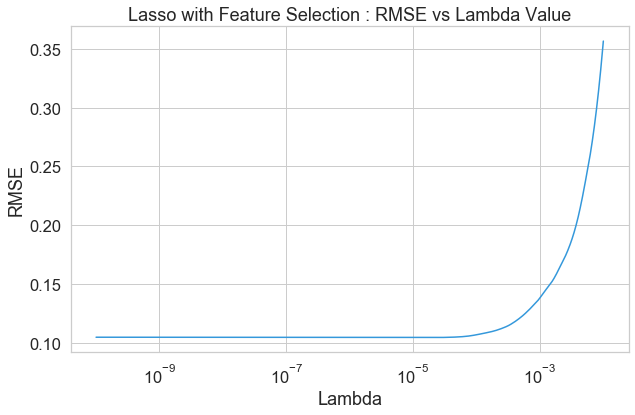

In [10]:
#New instance of model
lasso = Lasso(normalize=True, random_state=0)

#Perform gridsearch
# min_a = -7
# max_a = -2
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter



param_grid = {"alpha": np.linspace(10**-10, 10**-2, 2000)} #hyperparameter
grid = GridSearchCV(estimator=lasso, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train[imp_feat], y_train) #fit training data to model
lasso_selectFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(lasso_selectFeatures, open('saved_models/lasso_selectFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Lasso: Selected Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
# plt.xlim(10 ** min_a, 10 ** max_a)
# plt.ylim(0.10, 0.350)
plt.title("Lasso with Feature Selection : RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/lasso_selectFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = lasso_selectFeatures.predict(test_df[imp_feat]) #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/lasso_selectFeat_results.csv',index=False)

### Ridge Regularized Regression


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 7324 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   39.3s finished


Ridge: All Features
Best Lambda:0.2136068
Train RMSE:0.11335


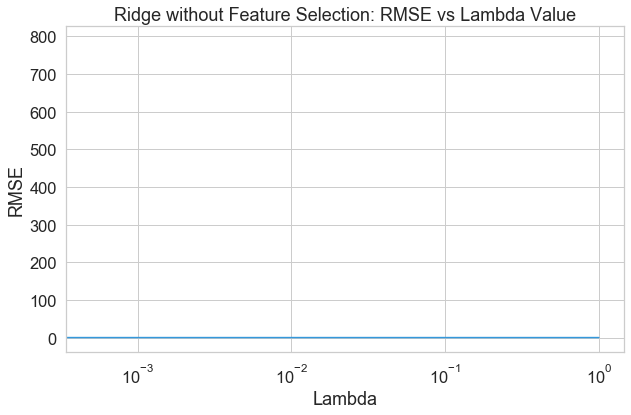

In [11]:
#New instance of model
ridge = Ridge(normalize=True, random_state=0)

# #Perform gridsearch
# min_a = -3
# max_a = 3
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter



param_grid = {"alpha": np.linspace(-1, 1, 2000)} #hyperparameter
grid = GridSearchCV(estimator=ridge, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train, y_train) #fit training data to model
ridge_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(ridge_allFeatures, open('saved_models/ridge_allFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Ridge: All Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
# plt.xlim(10 ** min_a, 10 ** max_a)
# plt.ylim(0.10, 0.40)
plt.title("Ridge without Feature Selection: RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/ridge_allFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = ridge_allFeatures.predict(test_df).squeeze() #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/ridge_allFeat_results.csv',index=False)


### Ridge Regularized Regression with Feature Selection
- Feature importance determined with Lasso model

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   16.9s finished


Ridge: Selected Features
Best Lambda:0.04052026
Train RMSE:0.10405


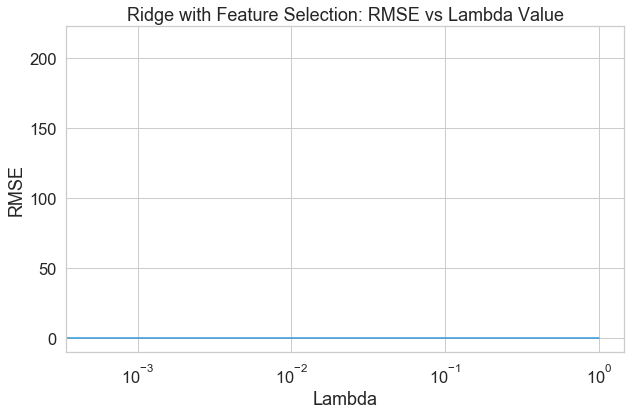

In [12]:
#New instance of model
ridge = Ridge(normalize=True, random_state=0)

# #Perform gridsearch
# min_a = -3
# max_a = 3
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter


param_grid = {"alpha": np.linspace(-1, 1, 2000)} #hyperparameter
grid = GridSearchCV(estimator=ridge, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train[imp_feat], y_train) #fit training data to model
ridge_selectFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(ridge_selectFeatures, open('saved_models/ridge_selectFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Ridge: Selected Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
# plt.xlim(10 ** min_a, 10 ** max_a)
# plt.ylim(0.10, 0.40)
plt.title("Ridge with Feature Selection: RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/ridge_selectFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = ridge_selectFeatures.predict(test_df[imp_feat]).squeeze() #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/ridge_selectFeat_results.csv',index=False)


### ElasticNet Regularized Regression 

In [13]:
#New instance of model
elastic = ElasticNet(normalize=True, random_state=0)

# #Perform gridsearch
# min_a = -7
# max_a = -2
# param_grid = {"alpha": np.logspace(min_a, max_a, 100),
#               'l1_ratio': [x / 100 for x in range(55, 75, 1)]} #hyperparameter



param_grid = {'alpha': np.linspace(10**-6, 10**-2, 1000),
              'l1_ratio': [x / 100 for x in range(50, 71, 1)]}
grid = GridSearchCV(estimator=elastic, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train, y_train) #fit training data to model
elastic_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(elastic_allFeatures, open('saved_models/elastic_allFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("ElasticNet: All Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Best l1_ratio:{0}".format(round(grid.best_params_["l1_ratio"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

#Export Data for kaggle
y_pred = elastic_allFeatures.predict(test_df) #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/elastic_allFeat_results.csv',index=False)


Fitting 5 folds for each of 21000 candidates, totalling 105000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 4360 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 6560 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 11108 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 17108 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 23908 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 31508 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 39908 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 49108 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 59108 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 69908 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 81508 ta

ElasticNet: All Features
Best Lambda:0.00018116
Best l1_ratio:0.63
Train RMSE:0.10948


[Parallel(n_jobs=-1)]: Done 105000 out of 105000 | elapsed:  4.1min finished


### Gradient Boosting Regression

In [14]:
# New instance of model
gb_model = GradientBoostingRegressor(random_state=0)

#Perform randomized search due to numbe of hyperparameters
param_grid = {'learning_rate': np.linspace(0.001, 1, 20),
              'loss': ['ls','huber'],
              'max_depth': range(2,11,2), #max depth of tree
              'max_features': ['sqrt','log2'], #n for considering a best split
              'min_samples_leaf': range(1,20,2),
              'min_samples_split': range(1,31, 5),
              'n_estimators': range(100,3500, 100)
             }

grid = RandomizedSearchCV(estimator=gb_model,
                          param_distributions=param_grid, 
                          n_iter=3500, #n parameter settings sampled
                          scoring="neg_root_mean_squared_error", #eval metric
                          verbose=True, #return status update
                          cv=5,
                          n_jobs=-1)
grid.fit(x_train, y_train) #fit training data to model
gb_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(gb_allFeatures, open('saved_models/gb_allFeatures', 'wb')) #save the model


# Print results
rmse_train = -grid.best_score_  # best rmse of training dataset

print("XGB: All Features")
print("Best learning_rate:{0}".format(round(grid.best_params_["learning_rate"], 8)))
print("Best loss:{0}".format(grid.best_params_["loss"]))
print("Best max_depth:{0}".format(round(grid.best_params_["max_depth"], 8)))
print("Best max_features:{0}".format(grid.best_params_["max_features"]))
print("Best min_samples_leaf:{0}".format(round(grid.best_params_["min_samples_leaf"], 8)))
print("Best min_samples_split:{0}".format(round(grid.best_params_["min_samples_split"], 8)))
print("Best n_estimators:{0}".format(round(grid.best_params_["n_estimators"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Export Data for kaggle
y_pred = gb_allFeatures.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/gb_allFeatures_results.csv", index=False)


Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 42.7min finished


XGB: All Features
Best learning_rate:0.01
Best loss:huber
Best max_depth:4
Best max_features:sqrt
Best min_samples_leaf:9
Best min_samples_split:26
Best n_estimators:2500
Train RMSE:0.1081


### XGBoost Regression

In [15]:
# New instance of model
xgb_model = xgb.XGBRegressor(normalize=True, 
                             random_state=0, 
                             objective ='reg:squarederror')

#Perform randomized search due to numbe of hyperparameters
param_grid = {'alpha': np.linspace(0.01, 1, 20), #L1 Lasso regularization
              'colsample_bytree': np.linspace(0.01, 1, 20), #frac of col. used per tree
              'eta': np.linspace(0.01, 1, 20), # learning rate
              'gamma': np.linspace(0.01, 1, 20), #specifies min loss reduction for split
              'lambda': np.linspace(0.01, 1, 20), #L2 Ridge regularization
              'max_depth': range(2,11,2), #max depth of tree
              'min_child_weight': [1, 1.5, 1.75, 2, 3], #min sum weights required in child
              'subsample': np.linspace(0.01, 1, 20), #frac of obvs. randomly sampled per tree
              'n_estimators': range(50,1500, 50), #number of trees
             }
grid = RandomizedSearchCV(estimator=xgb_model,
                          param_distributions=param_grid, 
                          n_iter=3500, #n parameter settings sampled
                          scoring="neg_root_mean_squared_error", #eval metric
                          verbose=True, #return status update
                          cv=5,
                          n_jobs=-1)
grid.fit(x_train, y_train) #fit training data to model
xgb_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(xgb_allFeatures, open('saved_models/xgb_allFeatures', 'wb')) #save the model


# Print results
rmse_train = -grid.best_score_  # best rmse of training dataset

print("XGB: All Features")
print("Best alpha:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Best colsample_bytree:{0}".format(round(grid.best_params_["colsample_bytree"], 8)))
print("Best eta:{0}".format(round(grid.best_params_["eta"], 8)))
print("Best gamma:{0}".format(round(grid.best_params_["gamma"], 8)))
print("Best max_depth:{0}".format(round(grid.best_params_["max_depth"], 8)))
print("Best min_child_weight:{0}".format(round(grid.best_params_["min_child_weight"], 8)))
print("Best n_estimators:{0}".format(round(grid.best_params_["n_estimators"], 8)))
print("Best subsample:{0}\n".format(round(grid.best_params_["subsample"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Export Data for kaggle
y_pred = xgb_allFeatures.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/xgb_allFeatures_results.csv", index=False)


Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 94.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 114.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 134.1min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 139.4min finished


XGB: All Features
Best alpha:0.63526316
Best colsample_bytree:0.21842105
Best eta:0.94789474
Best gamma:0.01
Best max_depth:4
Best min_child_weight:3
Best n_estimators:1300
Best subsample:0.89578947

Train RMSE:0.11334


## Higher Level Models

### Average Model

In [16]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # Clone the original models and fit the model with data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Average the predictions together
    def predict(self, X):
        y_pred = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(y_pred, axis=1) 

In [18]:
avg_stack_model = AveragingModels(models = (lasso_allFeatures, 
                                            ridge_allFeatures, 
                                            elastic_allFeatures, 
                                            gb_allFeatures, 
                                            xgb_allFeatures))

# Train model
avg_stack_model.fit(train_df, response)

# Assess performance
from preprocess_module import calc_rmse
rmse_train, error_train = calc_rmse(avg_stack_model, train_df, response)
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Mean Error: ${0}".format(round(error_train, 2)))
y_pred = avg_stack_model.predict(test_df)

# Export Data for kaggle
y_pred = avg_stack_model.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/avg_stack_results.csv", index=False)


Train RMSE:0.10493
Mean Error: $69582.02


### StackedRegressor: Lasso Meta-Regressor

In [19]:
stack_reg_lasso_model = StackingCVRegressor(regressors=(lasso_allFeatures,
                                                        ridge_allFeatures,
                                                        elastic_allFeatures,
                                                        gb_allFeatures,
                                                        xgb_allFeatures),
                                      meta_regressor=lasso_allFeatures,
                                      random_state=0, 
                                      use_features_in_secondary=True)


print('5-fold cross validation scores:\n')
for clf, label in zip([lasso_allFeatures, 
                       ridge_allFeatures, 
                       elastic_allFeatures, 
                       gb_allFeatures,
                       xgb_allFeatures, 
                       stack_reg_lasso_model], ['Lasso',
                                                'Ridge',
                                                'ElasticNet',
                                                'GradientBoost',
                                                'XGBoost',
                                                'StackingCVRegressor']):
    scores = cross_val_score(clf, np.array(train_df), np.array(response), cv=5, scoring='neg_root_mean_squared_error')
    print("RMSE Score:{0} [{1}]".format(round(-scores.mean(),5), label))

# Train model
stack_reg_lasso_model.fit(np.array(train_df), np.array(response))
y_pred = stack_reg_lasso_model.predict(np.array(train_df))

# Export Data for kaggle
y_pred = stack_reg_lasso_model.predict(np.array(test_df))
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/stack_reg_lasso_results.csv", index=False)


5-fold cross validation scores:

RMSE Score:0.10812 [Lasso]
RMSE Score:0.11284 [Ridge]
RMSE Score:0.10856 [ElasticNet]
RMSE Score:0.10481 [GradientBoost]
RMSE Score:0.11121 [XGBoost]
RMSE Score:0.10413 [StackingCVRegressor]


### StackedRegressor: XGBoost Meta-Regressor

In [20]:
stack_reg_xgb_model = StackingCVRegressor(regressors=(lasso_allFeatures,
                                                      ridge_allFeatures,
                                                      elastic_allFeatures,
                                                      gb_allFeatures,
                                                      xgb_allFeatures),
                                      meta_regressor=xgb_allFeatures,
                                      random_state=0, 
                                      use_features_in_secondary=True)


print('5-fold cross validation scores:\n')
for clf, label in zip([lasso_allFeatures, 
                       ridge_allFeatures, 
                       elastic_allFeatures, 
                       gb_allFeatures,
                       xgb_allFeatures, 
                       stack_reg_xgb_model], ['Lasso',
                                              'Ridge',
                                              'ElasticNet',
                                              'GradientBoost',
                                              'XGBoost',
                                              'StackingCVRegressor']):
    scores = cross_val_score(clf, np.array(train_df), np.array(response), cv=5, scoring='neg_root_mean_squared_error')
    print("RMSE Score:{0} [{1}]".format(round(-scores.mean(),5), label))

# Train model
stack_reg_xgb_model.fit(np.array(train_df), np.array(response))
y_pred = stack_reg_xgb_model.predict(np.array(train_df))

# Export Data for kaggle
y_pred = stack_reg_xgb_model.predict(np.array(test_df))
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/stack_reg_xgb_model.csv", index=False)



5-fold cross validation scores:

RMSE Score:0.10812 [Lasso]
RMSE Score:0.11284 [Ridge]
RMSE Score:0.10856 [ElasticNet]
RMSE Score:0.10481 [GradientBoost]
RMSE Score:0.11121 [XGBoost]
RMSE Score:0.10796 [StackingCVRegressor]


In [21]:
#Reduce the number of regressors
stack_reg_xgb_model = StackingCVRegressor(regressors=(lasso_allFeatures,
#                                                       ridge_allFeatures,
                                                      elastic_allFeatures,
                                                      gb_allFeatures,
                                                      xgb_allFeatures),
                                      meta_regressor=xgb_allFeatures,
                                      random_state=0, 
                                      use_features_in_secondary=True)


print('5-fold cross validation scores:\n')
for clf, label in zip([lasso_allFeatures, 
                       ridge_allFeatures, 
                       elastic_allFeatures, 
                       gb_allFeatures,
                       xgb_allFeatures, 
                       stack_reg_xgb_model], ['Lasso',
                                              'Ridge',
                                              'ElasticNet',
                                              'GradientBoost',
                                              'XGBoost',
                                              'StackingCVRegressor']):
    scores = cross_val_score(clf, np.array(train_df), np.array(response), cv=5, scoring='neg_root_mean_squared_error')
    print("RMSE Score:{0} [{1}]".format(round(-scores.mean(),5), label))

# Train model
stack_reg_xgb_model.fit(np.array(train_df), np.array(response))
y_pred = stack_reg_xgb_model.predict(np.array(train_df))

# Export Data for kaggle
y_pred = stack_reg_xgb_model.predict(np.array(test_df))
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/stack_reg_xgb_model2.csv", index=False)

5-fold cross validation scores:

RMSE Score:0.10812 [Lasso]
RMSE Score:0.11284 [Ridge]
RMSE Score:0.10856 [ElasticNet]
RMSE Score:0.10481 [GradientBoost]
RMSE Score:0.11121 [XGBoost]
RMSE Score:0.10629 [StackingCVRegressor]
